In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data

In [0]:
path_train = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/valid/'
path_valid = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/'
batch_size = 50

In [0]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [6]:
tgtnames = trainset.classes
tgtnames

['normal', 'not_normal', 'opacity']

In [7]:
validset

Dataset ImageFolder
    Number of datapoints: 300
    Root location: /content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

## Batch Normalization

In [8]:
X = torch.arange(0,8.,1).reshape((1,2,2,2))
print('X=',X)
bn = nn.BatchNorm2d(2)
print('BN(X)=',bn(X))

print('scale of BN:',bn.weight.data)
print('bias of BN:',bn.bias.data)

X= tensor([[[[0., 1.],
          [2., 3.]],

         [[4., 5.],
          [6., 7.]]]])
BN(X)= tensor([[[[-1.3416, -0.4472],
          [ 0.4472,  1.3416]],

         [[-1.3416, -0.4472],
          [ 0.4472,  1.3416]]]], grad_fn=<NativeBatchNormBackward>)
scale of BN: tensor([1., 1.])
bias of BN: tensor([0., 0.])


## Architecture: ResNet

In [0]:
# setting hyper-parameters
learning_rate = 0.05
num_epochs = 80
num_workers = 0

In [0]:
class Residual(nn.Module):
  
  def __init__(self,input_channels, num_channels, use_1x1conv=False, strides=1, **kwargs):
    super(Residual, self).__init__(**kwargs)
    self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X):
    
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    Y =self.relu(Y)
    return Y

In [0]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [0]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))

resnet=nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveMaxPool2d((1,1)),Flatten(),nn.Linear(512, 3))
resnet

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [0]:
#Initialization of Weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
resnet.apply(init_weights)
resnet = resnet.to(device)


# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(resnet.parameters(),lr=learning_rate) # sgd

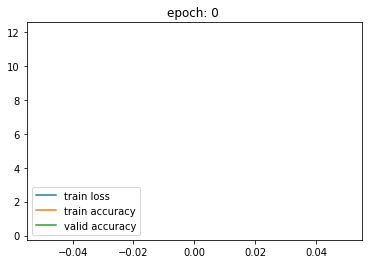

train loss:  11.978712972005209
train accuracy:  0.3400000035762787
valid accuracy:  0.3333333432674408


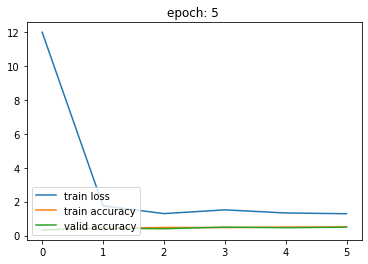

train loss:  1.286873499552409
train accuracy:  0.5093333125114441
valid accuracy:  0.4933333396911621


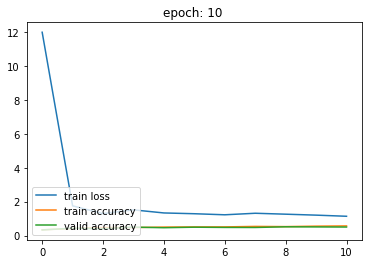

train loss:  1.1372095743815105
train accuracy:  0.5686666369438171
valid accuracy:  0.503333330154419


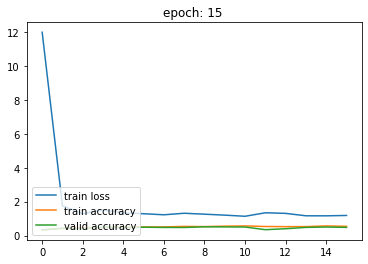

train loss:  1.1851608276367187
train accuracy:  0.5433333516120911
valid accuracy:  0.4833333194255829


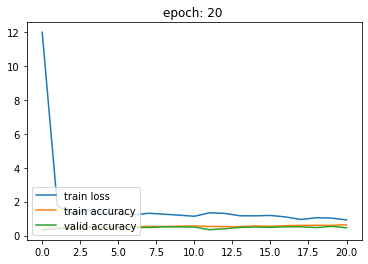

train loss:  0.9226308186848958
train accuracy:  0.6380000114440918
valid accuracy:  0.46000000834465027


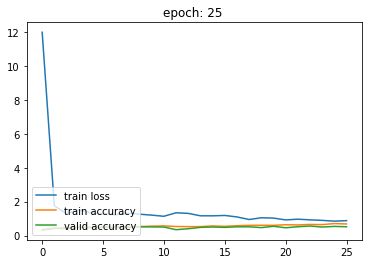

train loss:  0.8800298690795898
train accuracy:  0.6833333373069763
valid accuracy:  0.5199999809265137


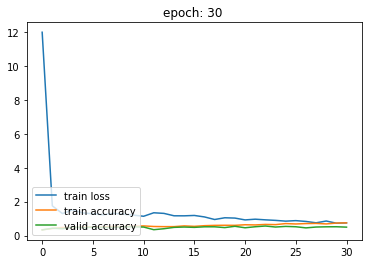

train loss:  0.7480581283569336
train accuracy:  0.7473333477973938
valid accuracy:  0.49666666984558105


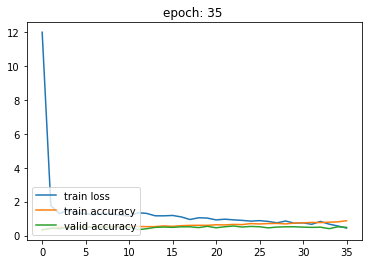

train loss:  0.44337218602498374
train accuracy:  0.8726666569709778
valid accuracy:  0.4833333194255829


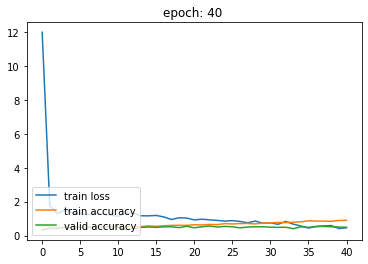

train loss:  0.4603203455607096
train accuracy:  0.8966666460037231
valid accuracy:  0.4866666793823242


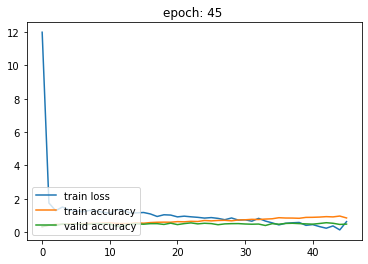

train loss:  0.6388100941975912
train accuracy:  0.8579999804496765
valid accuracy:  0.49000000953674316


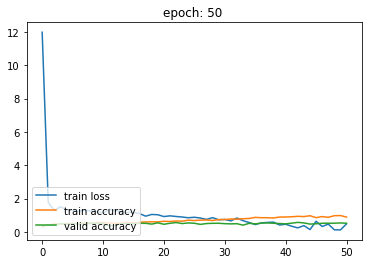

train loss:  0.48333985010782876
train accuracy:  0.8899999856948853
valid accuracy:  0.5199999809265137


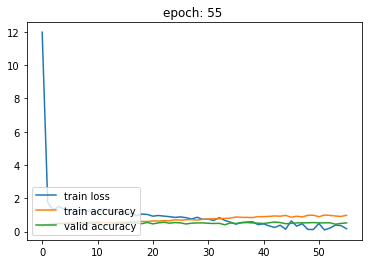

train loss:  0.1680729866027832
train accuracy:  0.9786666631698608
valid accuracy:  0.5199999809265137


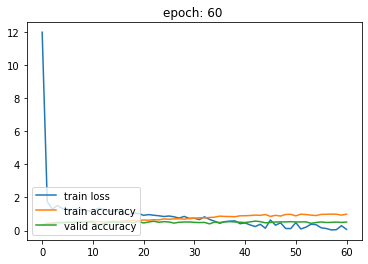

train loss:  0.07528957525889078
train accuracy:  0.9900000095367432
valid accuracy:  0.5166666507720947


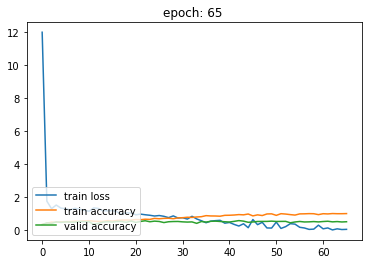

train loss:  0.042975425720214844
train accuracy:  0.9973333477973938
valid accuracy:  0.503333330154419


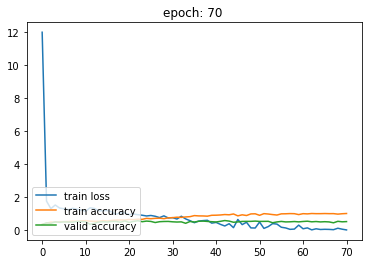

train loss:  0.005704626937707265
train accuracy:  1.0
valid accuracy:  0.5099999904632568


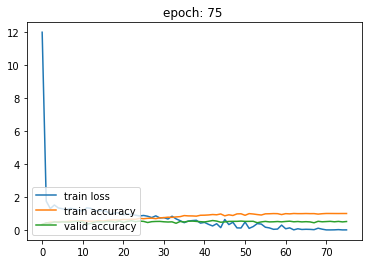

train loss:  0.006366954743862152
train accuracy:  0.9986666440963745
valid accuracy:  0.5133333206176758


In [15]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  resnet.train()
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=resnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  resnet.eval()
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = resnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

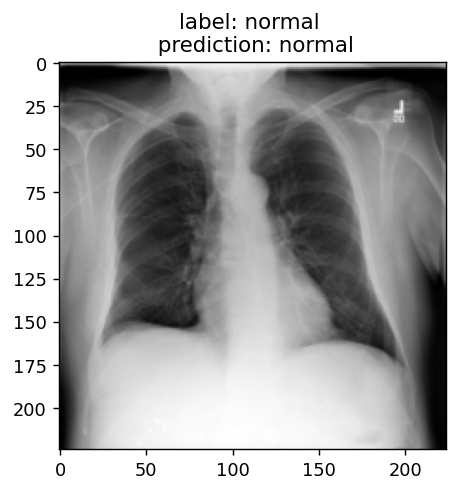

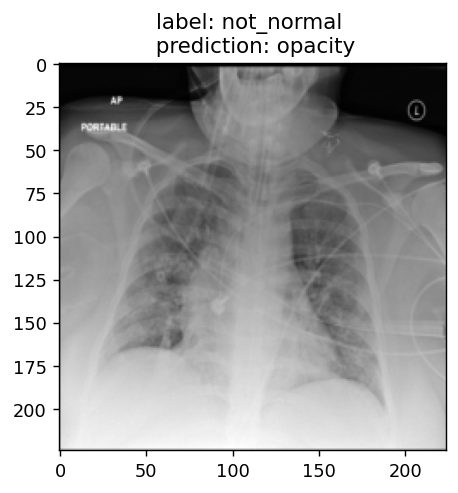

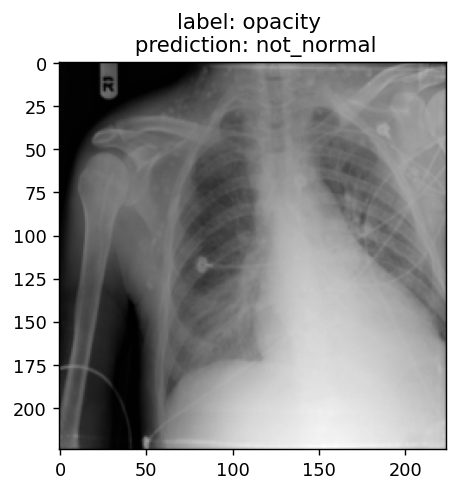

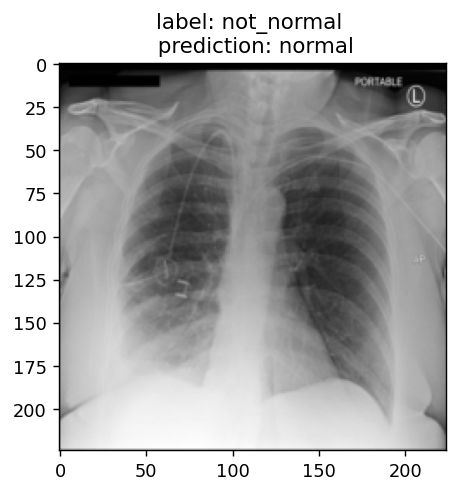

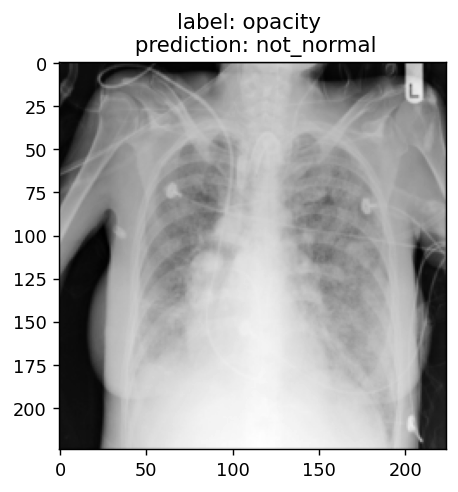

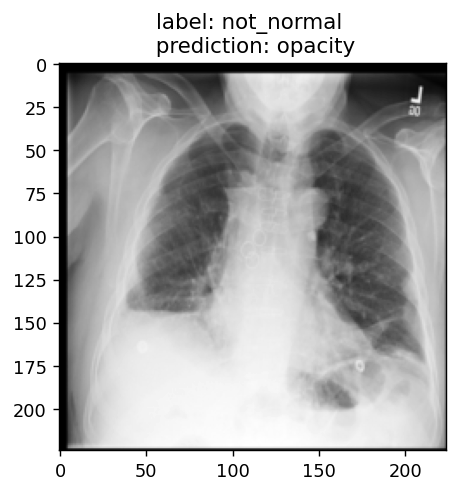

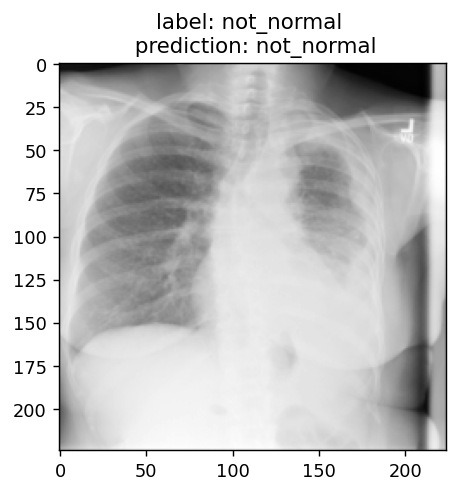

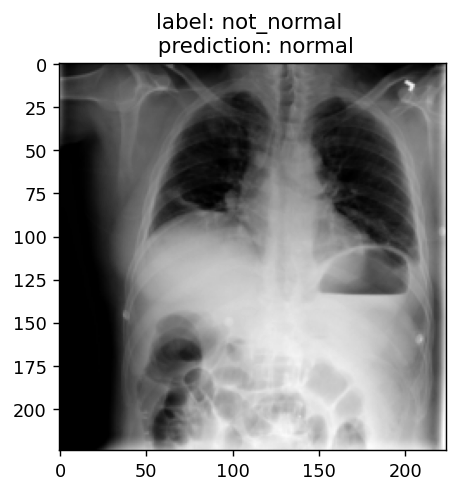

In [16]:
i = 0
resnet.eval()
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = resnet(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>0:
     break